# Hash model
- https://papers.nips.cc/paper/4808-hamming-distance-metric-learning.pdf
- https://arxiv.org/pdf/1702.00758.pdf
- https://stackoverflow.com/questions/37479119/doing-pairwise-distance-computation-with-tensorflow

In [4]:
import tensorflow as tf
import numpy as np
from scipy import spatial

try:
    if global_run_tests:
        pass
except:
    global_run_tests = True
_hashmod_grt = global_run_tests
global_run_tests = False

%run dataset.ipynb
%run visualisation.ipynb
%run augmentator.ipynb

global_run_tests = _hashmod_grt

_hash_model = None

In [124]:
class HashModel():
    def __init__(self, dataset, augmentator, out_dims):
        self.data       = dataset
        self._aug       = augmentator
        self.out_dims   = out_dims
        self._session   = None
        self._graph     = None
        
    def _make_nn(self, images, out_dim, reuse):
        def conv2d_maxpool(inputs, filters, name, reuse, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
            l = tf.layers.conv2d(
                inputs      = inputs,
                filters     = filters,
                kernel_size = kernel_size,
                padding     = padding,
                activation  = tf.nn.relu,
                reuse       = reuse,
                name        = name
            )
            l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
            return l
        
        l = images
        l = conv2d_maxpool(l, 16,  reuse=reuse, name='conv1')
        l = conv2d_maxpool(l, 32,  reuse=reuse, name='conv2')
        l = conv2d_maxpool(l, 64,  reuse=reuse, name='conv3')
        l = conv2d_maxpool(l, 128, reuse=reuse, name='conv4')
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=300,     activation=tf.nn.relu, reuse=reuse, name='fc1')
        l = tf.layers.dense(l, units=out_dim, activation=tf.nn.tanh, reuse=reuse, name='fc2')
        return l

    def _make_loss(self, out1, out2, labels, margin):
        l2_loss_pairs = tf.reduce_sum(tf.square(out1 - out2), axis=1)
        positive_loss = l2_loss_pairs
        negative_loss = tf.nn.relu(margin - l2_loss_pairs)
        final_loss = labels*positive_loss + (1.-labels)*negative_loss
        final_loss = tf.reduce_mean(final_loss)
        return final_loss

    def build(self, margin = 1):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        image_shape = self.data.image_shape
        data_size   = self.data.data_size
        with self._graph.as_default(), tf.name_scope('hashing'), tf.device('/gpu:0'):
            
            # placeholders
            self.image1_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image1')
            self.image2_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image2')
            self.labels_pl = tf.placeholder(dtype=tf.float32, shape=[None,], name='labels')
            self.lr_pl     = tf.placeholder(dtype=tf.float32, name='lr')

            # network
            self.nn_out1   = self._make_nn(self.image1_pl, self.out_dims, reuse=False)
            self.nn_out2   = self._make_nn(self.image2_pl, self.out_dims, reuse=True)
            
            # operations
            self.loss_op   = self._make_loss(self.nn_out1, self.nn_out2, self.labels_pl, margin=margin)
            self.train_op  = tf.train.AdamOptimizer(self.lr_pl).minimize(self.loss_op)
            self.init_op   = tf.global_variables_initializer()
            
        self._session = tf.Session(graph=self._graph)
        self._session.run(self.init_op)
        
    def train(self, step_num, batch_size, learning_rate, log_every=10):
        def augment(imgs):
            augmented = np.zeros_like(imgs)
            for i in range(len(imgs)):
                augmented[i] = self._aug.augment(imgs[i])
            return augmented
           
        try:
            losses = []
            for step in range(step_num):
                img1, img2, labels = self.data.get_next_batch(batch_size, self._aug.augment)
                labels = labels[:,1]
                _, loss = self._session.run([self.train_op, self.loss_op], feed_dict={
                    self.image1_pl: img1,
                    self.image2_pl: img2,
                    self.labels_pl: labels,
                    self.lr_pl    : learning_rate,
                })
                losses.append(loss)
                if step % log_every == log_every-1:
                    show_losses(losses, step, step_num)
        except KeyboardInterrupt:
            pass
        show_losses(losses, step, step_num)
        
    def embed_images(self, imgs, batch_size=100):
        embeds = np.zeros(shape=[len(imgs), self.embed_dims])
        bs = min(len(imgs), batch_size)
        for i in range(len(imgs)//bs):
            batch = imgs[i*bs:(i+1)*bs,:]
            embeds[i*bs:(i+1)*bs,:] = self._session.run(self.embed_op, feed_dict = {self.images_pl : batch})
        return embeds

## Create model

In [129]:
%%time
def create_model(image_shape, data_size, out_dims, aug_num):
    data = Dataset(image_shape)
    data.load(_dataset_path, data_size)
    aug  = Augmentator(cache_size = aug_num)
    
    model = HashModel(data, aug, out_dims)
    model.build()
    return model

if global_run_tests:
    _hash_model = create_model(
        image_shape = [128,128,1],
        data_size   = 300,
        out_dims    = 32,
        aug_num     = 10)

CPU times: user 2.36 s, sys: 44 ms, total: 2.4 s
Wall time: 2.39 s


## Train model

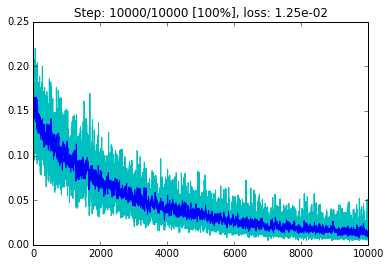

CPU times: user 1h 10min 26s, sys: 44min 7s, total: 1h 54min 33s
Wall time: 1h 5min 50s


In [131]:
%%time
def test_train_model(model, step_num, batch_size, learning_rate):
    model.train(step_num=step_num, batch_size=batch_size, learning_rate=learning_rate)

if global_run_tests:
    test_train_model(
        model         = _hash_model,
        step_num      = 10000,
        batch_size    = 64,
        learning_rate = 1e-4)

In [132]:
%%time
def save_model(model, path):
    with model._graph.as_default(), tf.name_scope('hashing'):
        saver = tf.train.Saver()
    saver.save(model._session, path)

def restore_model(image_shape, embed_dims, aug_num, model_path):
    model = create_model(image_shape, embed_dims, aug_num)
    saver = tf.train.Saver(var_list=tf.get_collection(key=tf.GraphKeys.GLOBAL_VARIABLES))
    saver.restore(model._session, path)
    
if global_run_tests:
    save_model(_hash_model, "data/hash_model/")

CPU times: user 1.82 s, sys: 48 ms, total: 1.86 s
Wall time: 1.84 s


In [ ]:
# todo -- get batch and show outputs
# binarize outputs
# build database
